# Agentic AI Weather Agent with Tomorrow. and Large Language Model

In [ ]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()

True

In [ ]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


Load Model

In [ ]:
model = "deepseek-r1-distill-llama-70b"
llm = ChatGroq(model = model)

In [6]:
response = llm.invoke("can you tell me capital of Punjab?").content

In [7]:
print(response)

<think>
Okay, so I need to figure out the capital of Punjab. Hmm, I'm not entirely sure, but I'll try to work it out. First, I remember that Punjab is a region in South Asia, but I think there might be two parts because of the partition of India and Pakistan. 

So, I think Punjab is divided into two states: one in India and one in Pakistan. I'm pretty sure that in India, the state of Punjab has a capital city. I've heard of Chandigarh before, maybe that's it? But wait, isn't Chandigarh also a Union Territory? I think Chandigarh serves as the capital for both Punjab and Haryana in India. That makes sense because sometimes states share capitals, especially if they're near each other or for administrative reasons.

Now, what about Pakistan? I believe there's a Punjab province there too. The capital of Pakistani Punjab, if I'm not mistaken, is Lahore. I've heard of Lahore as a major city in Pakistan, so that seems right. It's a big cultural hub, I think.

Wait, to make sure I'm not mixing 

# Working with tool

In [56]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage 
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode


In [9]:
# calling model for output
def call_llm(state: MessagesState):
    
    message = state["messages"]

    response = llm.invoke(message)

    return {"messages": [response]}


In [10]:
state = {"messages":["capital of maharastra?"]}
call_llm(state)

{'messages': [AIMessage(content="<think>\nOkay, so I need to figure out the capital of Maharashtra. I'm not entirely sure, but I'll try to work through it step by step.\n\nFirst, I know that Maharashtra is a state in India. I've heard of a few cities in India like Mumbai, Delhi, Bangalore, and Pune. I think Mumbai is a major city, maybe the biggest in Maharashtra. But is it the capital?\n\nI remember that sometimes the largest city isn't always the capital. For example, in the US, New York is the biggest city, but Washington D.C. is the capital. So maybe it's similar in India. I think the capital of India is New Delhi, so that's different from Mumbai.\n\nWait, but I'm pretty sure Mumbai is the capital of Maharashtra. I've heard that before. Let me think about other states. Like, Gujarat's capital is Gandhinagar, but the big city is Ahmedabad. So maybe in Maharashtra, the capital is Mumbai, which is also the biggest city.\n\nI don't think Pune is the capital, though it's a big city in M

# Building workflow with tool calling

In [11]:
import requests
from typing import Dict, Any

class weather_tool:

    def __init__(self,api_key:str):
        self.api_key = api_key,
        self.base_url = "https://api.tomorrow.io/v4/weather/realtime"

    def get_weather(self, location:str) -> Dict[str, Any]:

        """Fetch real time weather information from temorrow.io
        Args: 
        location: Place name(e.g: Mumbai)
        return:
        Dictionary with temperature, humidity and condition"""

        parameter ={"location":location,
                    "apikey":self.api_key 
                    }
        
        response = requests.get(url= self.base_url,params= parameter)

        if response.status_code !=200:
            return {"error": f"API request failed: {response.text}"}
        
        data = response.json()


        values = data.get("data", {}).get("values", {})

        return {
            "location": location,
            "temperature": values.get("temperature"),
            "humidity": values.get("humidity"),
            "wind_speed": values.get("windSpeed"),
            "condition": values.get("weatherCode")
        }
        

In [12]:
@tool
def Weather_Search(location:str):
    """Get real-time weather information for a given location"""
    weather_tools = weather_tool("9l3JxkG0LdZVa2qXEJckAoboAaFw8hEj")

    data = weather_tools.get_weather(location)
    return str(data)


In [47]:
Weather_Search.invoke("mumbai?")

"{'location': 'mumbai?', 'temperature': 29.3, 'humidity': 73, 'wind_speed': 3.4, 'condition': 1101}"

# Web Search Engine

In [16]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()

# Build LLM with tool

In [20]:
llm_with_tools = llm.bind_tools([Weather_Search,search])

In [52]:
response = llm_with_tools.invoke("Wheather of mumbai?")

In [53]:
response.tool_calls

[{'name': 'Weather_Search',
  'args': {'location': 'Mumbai'},
  'id': 'mz1y0c6kv',
  'type': 'tool_call'}]

In [54]:
response.content

''

In [55]:
response

AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, the user is asking about the weather in Mumbai. I need to figure out how to respond using the tools provided. I have access to the Weather_Search function, which requires a location parameter. \n\nFirst, I\'ll check if I can extract the location from the user\'s query. The query is "Wheather of mumbai?" which seems to have a typo but clearly mentions Mumbai. So, the location is Mumbai.\n\nNext, I\'ll construct the function call. The function name is Weather_Search, and the argument is an object with the location set to "Mumbai". \n\nI should make sure the JSON is correctly formatted, with proper quotes and commas. Also, I need to wrap the tool call within the specified XML tags as per the instructions.\n\nSo, the final tool call will include the function name and the arguments in the correct JSON format inside the <tool_call> tags.\n', 'tool_calls': [{'id': 'mz1y0c6kv', 'function': {'arguments': '{"location":"Mumba

# Using Langgraph to Build Agent

In [71]:
System_Message = SystemMessage("""You are a helpful assistant.  
You can use the **weather tool** to get real-time weather information,  
and the **search tool** for web searches.""")

tools = [Weather_Search,search]

def LLM_Call_Fun(state:MessagesState):

    user_query= state["messages"]

    input_query = [System_Message] + user_query

    response = llm_with_tools.invoke(input_query)
    
    return {"messages":[response]}

In [72]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

workflow.add_node("llm_decision_step",LLM_Call_Fun)

workflow.add_node("tools",ToolNode(tools))


workflow.add_conditional_edges("llm_decision_step",tools_condition)

workflow.add_edge(START,"llm_decision_step")

workflow.add_edge("tools","llm_decision_step")


In [73]:
react_agent = workflow.compile()

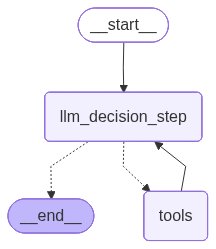

In [74]:
from IPython.display import Image, display
display(Image(react_agent.get_graph().draw_mermaid_png()))

In [79]:
message=[HumanMessage(content="What is current weather of mumbai?")]
messages = react_agent.invoke({"messages":message})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is current weather of mumbai?
================================== Ai Message ==================================
Tool Calls:
  Weather_Search (8qp1sfkpg)
 Call ID: 8qp1sfkpg
  Args:
    location: Mumbai
================================= Tool Message =================================
Name: Weather_Search

{'location': 'Mumbai', 'temperature': 30.3, 'humidity': 68, 'wind_speed': 3.1, 'condition': 1001}
================================== Ai Message ==================================

The current weather in Mumbai is as follows:

- Temperature: 30.3°C
- Humidity: 68%
- Wind Speed: 3.1 km/h
- Condition: 1001 (Clear Sky)

Let me know if you'd like further details!


In [80]:
message=[HumanMessage(content="Hello")]
messages = react_agent.invoke({"messages":message})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [82]:
message=[HumanMessage(content="lastest iphone updates?")]
messages = react_agent.invoke({"messages":message})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

lastest iphon updates?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (8nt8ha0yv)
 Call ID: 8nt8ha0yv
  Args:
    query: latest iPhone updates 2023
================================= Tool Message =================================
Name: duckduckgo_search

Latest news, in-depth features and opinion on Singapore, covering politics, economy, society and the city state’s relationships with China, Malaysia, and other Southeast Asian countries. Sep 26, 2025 · The latest military news, insights and analysis from China. Latest China military news, including US-China military tensions, China’s spending on defence and Beijing’s vow to increase its preparation for war. Latest news, in-depth features and opinion on Malaysia, covering politics, economy, society and the Asean member-nation’s relationships with China, Singapore, and other Southeast Asian … 